<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=125327440" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [52]:
#  ! pip install imutils -q

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

from datetime import datetime
import uuid


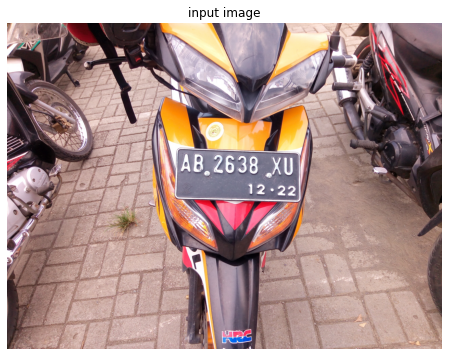

In [2]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB2638XU.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB5592EG.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AD2914JG.jpg')


arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

# program untuk mendeteksi posisi plat nomor dari motor


In [ ]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113718.jpg')

# grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
# blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
# edged   = cv2.Canny(blured, 10, 180)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
# dilate = cv2.dilate(edged, kernel, iterations=1)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# thresh_inv = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
thresh_inv  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blur = cv2.GaussianBlur(thresh_inv,(63,63),0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
edged   = cv2.Canny(thresh, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(thresh, kernel, iterations=1)

contours,_ = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()

i=0
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if h>450 and w>1500 and w/h < 2.3:
        print(f'aspect: {w/h}, ')
        cv2.drawContours(image_copy, contours, i, (0,0,255), 4)
    i+=1

# plt.imshow(thresh)
display(image_copy)

In [3]:
indeximg=0
filepath=[]
for root, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber'):
    for file in filename:
        filepath.append(os.path.join(root, file))

# FULL PROGRAM

aspect ratio from index: 3062, 2.2348336594911937, w: 2284, h: 1022
aspect ratio from index: 3063, 1.9004830917874396, w: 1967, h: 1035
aspect ratio from index: 3660, 2.3891625615763545, w: 970, h: 406
detected plat no: 3, index: 18


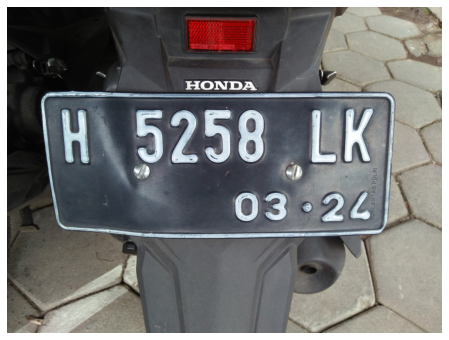

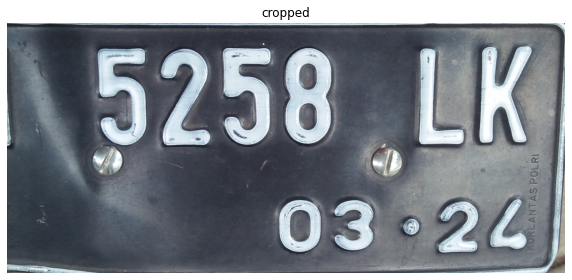

x: 630, y: 104, w: 202, h: 398
x: 632, y: 106, w: 198, h: 394
x: 1685, y: 102, w: 185, h: 395
x: 1687, y: 105, w: 181, h: 389
x: 369, y: 102, w: 202, h: 399
x: 372, y: 104, w: 197, h: 394
x: 1138, y: 101, w: 190, h: 394
x: 1140, y: 103, w: 186, h: 389
x: 877, y: 100, w: 204, h: 398
x: 883, y: 102, w: 195, h: 394
x: 1932, y: 94, w: 216, h: 397
x: 1934, y: 96, w: 212, h: 392
x: 2091, y: 65, w: 129, h: 236
detected candidate plat no: 13
[964, 953, 981, 969, 959, 996, 1023]


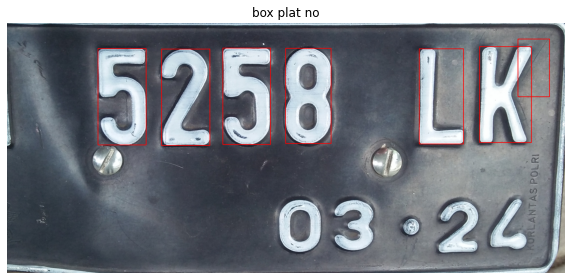

/kaggle/working/11_04_2023-02_10_58234abdde-d50c-4bb0-8da7-1f32bbff9c33.jpg


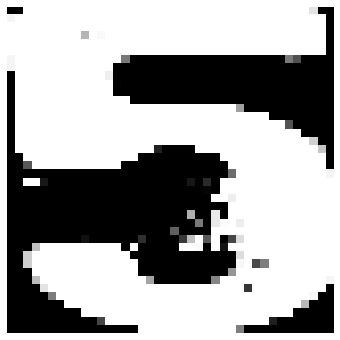

/kaggle/working/11_04_2023-02_10_581af9f817-632b-41eb-918c-7278ee0454a2.jpg


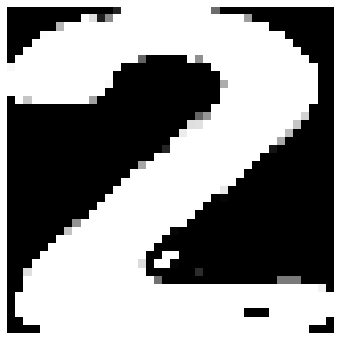

/kaggle/working/11_04_2023-02_10_583d5056e7-51d8-47bf-af9f-b089073d15df.jpg


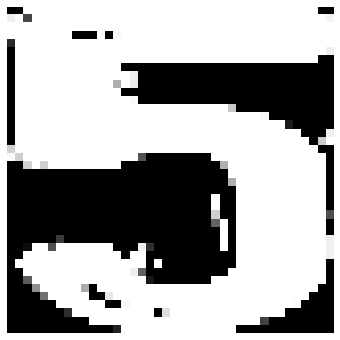

/kaggle/working/11_04_2023-02_10_58d4c3ccc2-f2d9-4e97-8915-8ec69b754889.jpg


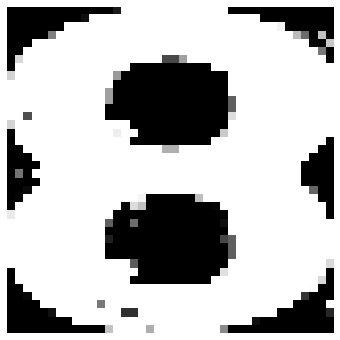

/kaggle/working/11_04_2023-02_10_58631ec855-6cab-43ea-be5e-dc106cde03fe.jpg


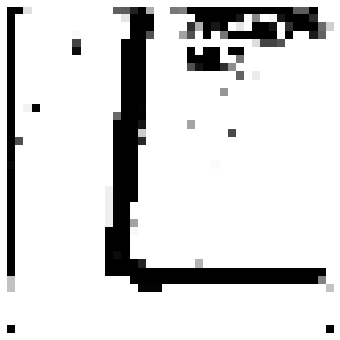

/kaggle/working/11_04_2023-02_10_584e1405b9-e8f0-47dd-b023-d01cbf7f56af.jpg


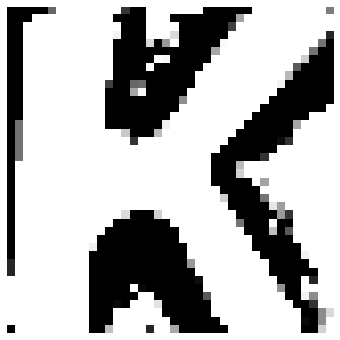

/kaggle/working/11_04_2023-02_10_58d41d0000-e4ce-444b-b13a-aa084e86336f.jpg


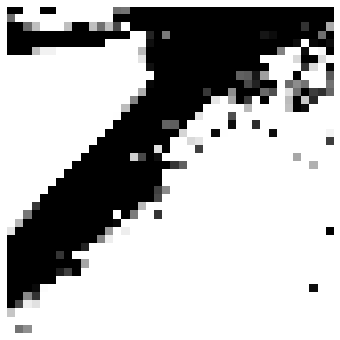

In [66]:
img = cv2.imread(filepath[indeximg])

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (21,21), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
        print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}, index: {indeximg}')

# plt.imshow(img)
display(img)
# display(dilate)
# display(image_copy)

if len(platno) >0:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    croppedimg = img[y: y+h, x:x+w]
    display(croppedimg, "cropped")
    
##########################################################################

grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
edged   = cv2.Canny(blured, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h

    if w > 120 and h>=150 and h <410 and aspect_ratio <= 0.7 :
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

urutx = []
for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    urutx.append(x)
urutx = sorted(urutx)

## urutkan karakter plat nomor dari kiri ke kanan
cropCharUrut=[]
for ux in urutx:
    for char in platno :
        x,y,w,h = cv2.boundingRect(contours[char])
        if x == ux: 
            cropCharUrut.append(char)
            break
o = 0
for c in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[c])
    o=0
    for i in cropCharUrut:
        if c==i:
            continue
        x2,y2,w2,h2 = cv2.boundingRect(contours[i])
        
        if abs(x-x2) < 10:
            cropCharUrut.pop(o)
        o+=1
print(cropCharUrut)

for c in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[c])
    cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

display(imgrec, "box plat no")

##########################################################################

# tampilkan karakter yang telah terpotong
imgs=[]
savepath='/kaggle/working/'
imgHeight = 40
imgWidth  = 40

for char in cropCharUrut:
    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
    filename = os.path.join(savepath, filename)
    print(filename)
    
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
    imgs.append(char_crop)
#     cv2.imwrite(filename, crop)
    display(char_crop)


# increment indeximg
indeximg +=1

aspect ratio from index: 1979, 2.5950570342205324, w: 2730, h: 1052
detected plat no: 1, index: 5


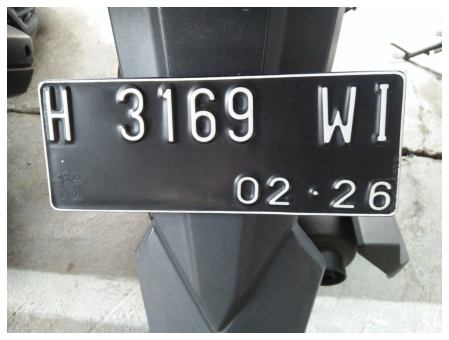

In [51]:
img = cv2.imread(filepath[indeximg])

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (21,21), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
        print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}, index: {indeximg}')

# plt.imshow(img)
display(img)
# display(dilate)
# display(image_copy)



In [ ]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113606.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113827.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113833.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113613.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410084106.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410084035.jpg')

# req = urllib.request.urlopen('https://t-2.tstatic.net/gorontalo/foto/bank/images/12102022_plat-nomor-putih.jpg')

# req = urllib.request.urlopen('https://image.cermati.com/q_70,w_1200,h_800,c_fit/cgbt1mggrzxkk5p5xtot')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    


grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (23,23), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)


image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0
sx = sy = sw = sh =[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 500 and h>350 and h<1100 and aspect_ratio <= 3 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
        print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) <=2:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
#     cv2.drawContours(detectedimg, contours, indexplatno, (0, 0, 255), 5)
    croppedimg = img[y: y+h, x:x+w]
    display(croppedimg, "cropped")

    
for p in platno:
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    cv2.rectangle(detectedimg, (x,y), (x+w, y+h), (0,0,255), 3)

print(indexplatno)

plt.imshow(img)

# display(hisimg, "contour")
# display(thresh, "edged")
# display(dilate, "position")
display(detectedimg, "position")
# display(image_copy, "dilated")
# display(croppedimg, "cropped")



# program untuk mendeteksi digit dari plat nomor motor

x: 1396, y: 8, w: 143, h: 272
x: 1399, y: 10, w: 138, h: 268
x: 1223, y: 6, w: 123, h: 263
x: 788, y: 0, w: 129, h: 253
x: 614, y: 0, w: 126, h: 250
x: 432, y: 0, w: 133, h: 246
x: 259, y: 0, w: 128, h: 245
detected candidate plat no: 7
[459, 458, 457, 456, 440, 439]


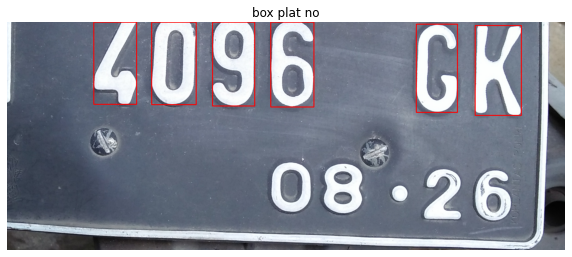

In [46]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC1.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6498SI.jpg')

# req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/a/a5/Plat_Nomor_Nganjuk_%283_Huruf%29.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1)

"""
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
edged   = cv2.Canny(blured, 10, 180)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)
"""

grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
edged   = cv2.Canny(blured, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h

    if w > 120 and h>=150 and h <410 and aspect_ratio <= 0.7 :
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

urutx = []
for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    urutx.append(x)
urutx = sorted(urutx)

## urutkan karakter plat nomor dari kiri ke kanan
cropCharUrut=[]
for ux in urutx:
    for char in platno :
        x,y,w,h = cv2.boundingRect(contours[char])
        if x == ux: 
            cropCharUrut.append(char)
            break
o = 0
for c in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[c])
    o=0
    for i in cropCharUrut:
        if c==i:
            continue
        x2,y2,w2,h2 = cv2.boundingRect(contours[i])
        
        if abs(x-x2) < 10:
            cropCharUrut.pop(o)
        o+=1
print(cropCharUrut)

for c in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[c])
    cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

display(imgrec, "box plat no")
# display(hisimg, "detected plat no")
# display(blured, "detected plat no")
# display(image_copy, "contour")
# display(edged, "edged")
# display(dilate, "dilated")


# **Selanjutnya buat program untuk ekstract setiap digit dari plat nomor dan melakukan klasifikasi karakter yang didapatkan**

/kaggle/working/11_04_2023-02_01_19081c5a86-5bdc-4590-9c47-515af5bdf025.jpg


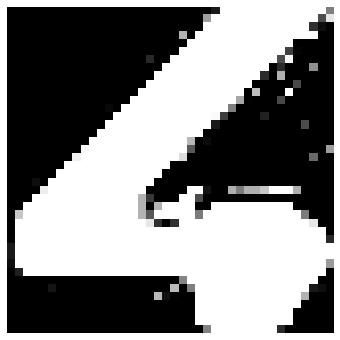

/kaggle/working/11_04_2023-02_01_19b125c120-7f94-4803-a46e-f3bb79057321.jpg


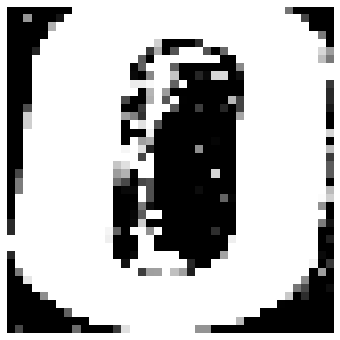

/kaggle/working/11_04_2023-02_01_19c4b32236-5557-45a8-9e94-2ef0975c5448.jpg


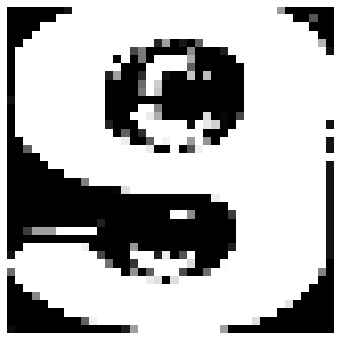

/kaggle/working/11_04_2023-02_01_206b7692f0-e4da-403a-b871-3dca9249835e.jpg


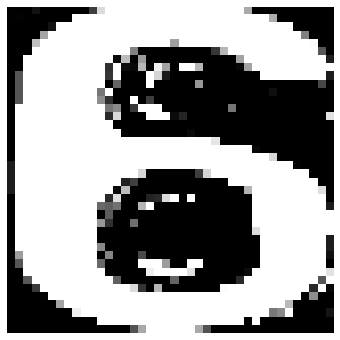

/kaggle/working/11_04_2023-02_01_20d0763b26-2f4c-4be4-ac0a-c76a43c614fc.jpg


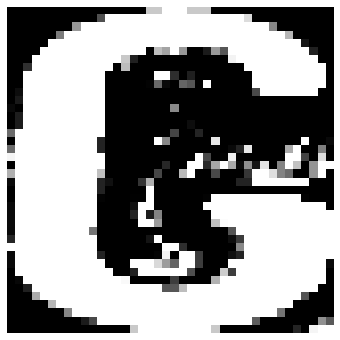

/kaggle/working/11_04_2023-02_01_20e4d06a0c-fdbc-4f95-a604-19bf6f664d4a.jpg


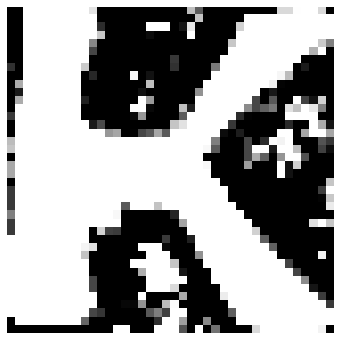

In [47]:
from datetime import datetime
import uuid

# tampilkan karakter yang telah terpotong
imgs=[]
savepath='/kaggle/working/'
imgHeight = 40
imgWidth  = 40

for char in cropCharUrut:
    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
    filename = os.path.join(savepath, filename)
    print(filename)
    
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
    imgs.append(char_crop)
#     cv2.imwrite(filename, crop)
    display(char_crop)


# buat 1 plot dan tampilkan 
# _, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
# axs = axs.flatten()
# for img, ax in zip(imgs, axs):
#     ax.imshow(img)
# plt.figtext(.5,.65,'Data Plat yang didapatkan',fontsize=30,ha='center')
# plt.show()

# Buat Model Untuk Klasifikasi 
## **Nek meh ubah" / edit, nggawe Cell dewe, trus jenengi, ngen ra bingung**

In [ ]:
"""
Cell nggone AH... Ojo diubah ubah
Buat Model dari tutorial:
https://www.tensorflow.org/tutorials/images/classification
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

path = '/kaggle/input/dataset-characters-indo-plate/dataset_characters'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

numClass = len(className)

# buat model dengan tensorflow sequential
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model.summary()

In [ ]:
epochs=10
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model') # Save trained model

In [41]:
model = keras.models.load_model('/kaggle/working/my_model')

# display(imgs[index])
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
predictedPlat=[]


for index in range(0, len(imgs)):
    image =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    char_crop = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
#     display(char_crop)

    # preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)
    # agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

#     print(class_names[np.argmax(score)])
#     ax.imshow(image)
    predictedPlat.append(class_names[np.argmax(score)])
    
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,predictedPlat,fontsize=30,ha='center')
plt.show()

OSError: SavedModel file does not exist at: /kaggle/working/my_model/{saved_model.pbtxt|saved_model.pb}

In [ ]:


for dirpath, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber/'):
    for file in filename:
#         print(file)
        print(os.sep.join([dirpath, file]))


